<a href="https://colab.research.google.com/github/bharatsoni0047/Langgraph--Multi-AI-RAG-chatbot-using-Astra-DB/blob/master/Multi_AI_RAG_chatbot_using_Langgraph_and_AsrtraDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi AI RAG chatbot using Langgraph and AsrtraDB

This notebook demonstrates a LangGraph-based RAG system with
dynamic routing between AstraDB vector search and Wikipedia,
followed by grounded answer generation using an LLM.

In [ ]:
!pip install langchain langgraph cassio

In [ ]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface arxiv wikipedia

In [ ]:
from google.colab import userdata
import cassio

ASTRA_DB_TOKEN = userdata.get("ASTRA_DB_TOKEN")
ASTRA_DB_ID = userdata.get("ASTRA_DB_ID")

cassio.init(
    token=ASTRA_DB_TOKEN,
    database_id=ASTRA_DB_ID
)

In [ ]:
### Build Index
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import WebBaseLoader
# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
from langchain_community.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

In [ ]:
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

Inserted 88 headlines.


In [ ]:
retriever=astra_vector_store.as_retriever()

In [ ]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

[Document(id='6d852b6369274141842fe90b5cb82773', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=userdata.get('GROQ_API_KEY')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")

In [ ]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
## Graph

from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[Document]

In [ ]:
from langchain_core.documents import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [ ]:
from langchain_core.documents import Document
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = Document(page_content=docs)

    return {
        "documents": [wiki_results],   # 👈 MUST be a list
        "question": question
    }

In [ ]:
def generate(state):
    print("---GENERATE ANSWER---")

    question = state["question"]
    docs = state["documents"]

    #context = "\n\n".join([d.page_content for d in docs])
    context = "\n\n".join([
    d[0].page_content if isinstance(d, tuple) else d.page_content
    for d in docs
])


    prompt = f"""
You are an expert assistant.
Answer the question ONLY using the context.

Context:
{context}

Question:
{question}
"""

    response = llm.invoke(prompt)
    return {"generation": response.content}


In [ ]:
import json

def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]

    prompt = f"""
You are a router.
Return ONLY valid JSON.

Allowed values:
- vectorstore
- wiki_search

Question: {question}

Output:
{{"datasource": "<value>"}}
"""

    response = llm.invoke(prompt)
    datasource = json.loads(response.content)["datasource"]

    return "wiki_search" if datasource == "wiki_search" else "vectorstore"


In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_node("generate", generate)

workflow.add_edge("retrieve", "generate")
workflow.add_edge("wiki_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

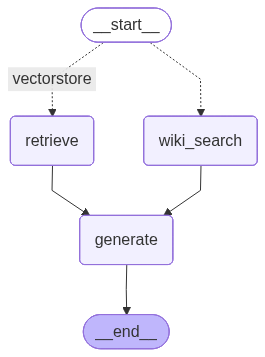

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from pprint import pprint

inputs = {"question": "What is agent?"}

final_state = None

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}'")
        final_state = value
    pprint("\n---\n")

# ✅ FINAL ANSWER
print("\nFINAL ANSWER:\n")
print(final_state["generation"])


---ROUTE QUESTION---
---RETRIEVE---


"Node 'retrieve'"
'\n---\n'
---GENERATE ANSWER---
"Node 'generate'"
'\n---\n'

FINAL ANSWER:

The agent is the LLM-powered autonomous system, which is capable of calling external APIs for extra information.


In [ ]:
from pprint import pprint

inputs = {
    "question": "grok vs chatgpt"
}

final_state = None

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}'")
        final_state = value
    pprint("\n---\n")

# ✅ FINAL ANSWER
print("\nFINAL ANSWER:\n")
print(final_state["generation"])


---ROUTE QUESTION---
---RETRIEVE---


"Node 'retrieve'"
'\n---\n'
---GENERATE ANSWER---
"Node 'generate'"
'\n---\n'

FINAL ANSWER:

{
  "thoughts": {
    "text": "Clarifying the difference between GROK and ChatGPT",
    "reasoning": "Understanding the context of the project GPT-Engineer and the user's previous statement",
    "plan": "- List the key features of GROK and ChatGPT\n- Identify the main differences between the two\n- Develop a plan to incorporate the user's preferences into the project\n- Consider the implications of using either GROK or ChatGPT for the project\n- Develop a long-term plan for the project's architecture and components",
    "criticism": "I should be careful not to assume the user's familiarity with GROK and ChatGPT, and ask clarifying questions if necessary",
    "speak": "To clarify, can you tell me what you mean by 'GROK vs ChatGPT' in the context of the Super Mario game project?"
  },
  "command": {
    "name": "ask_for_clarification",
    "args": {
      "question": "What do you mean by GROK